In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters

from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import square, disk, star, diamond, rectangle
from skimage.util import pad
from skimage import img_as_float32, img_as_ubyte, dtype_limits, img_as_float64, img_as_float


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.color import rgb2gray

In [2]:
#you can do as we did & download the image files and upload them to google drive 
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
#this allows you to slider through all the QPM images in order
im = np.zeros((600,800,285))
#most content in google drive starts as "'/content/drive/MyDrive/"
for i in range(285):
 im[:,:,i]=plt.imread('/content/drive/MyDrive/Colab_Notebooks/BRP/BRPC/phase{}.tif'.format(i))

def current_frame(i=0):
  fig, ax = plt.subplots(figsize=(8,8))

  ax.imshow(im[:,:,i], cmap='gray')
  ax.axis('off')

interact(current_frame, i=widgets.IntSlider(value=0, min=0, max=284, step=1))


interactive(children=(IntSlider(value=0, description='i', max=284), Output()), _dom_classes=('widget-interact'…

<function __main__.current_frame>

Start of Binary Mask Segmentation

In [9]:
im[:,:,0].shape
im1=im[:,:,0]
#min(im1)
max(im1[0,:])
#dtype_limits(im1)

909.0

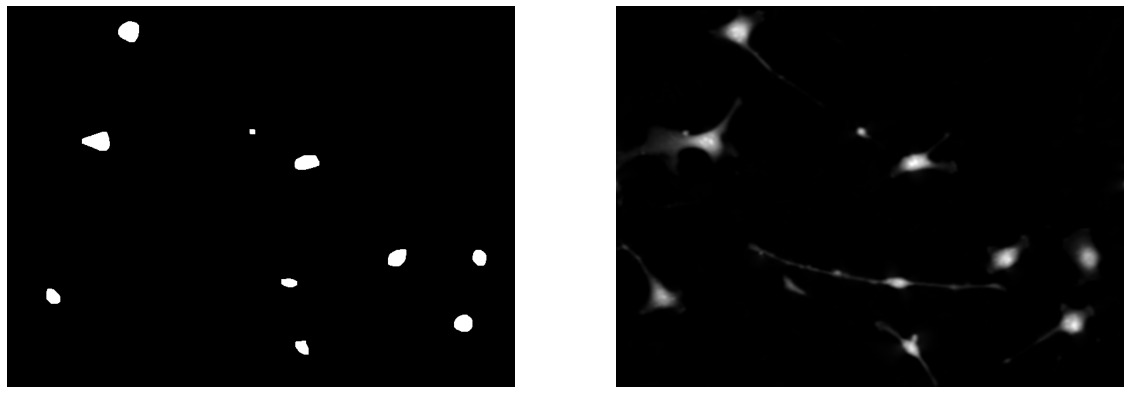

In [11]:
#compare the first binary mask image to the first raw image
tst= im1 > 20000

fig, ax = plt.subplots(ncols=2, figsize=(20,20))

ax[0].imshow(dilate(erode(tst,square(7)),square(7)), cmap='gray')
ax[1].imshow(im1, cmap='gray')

for axi in ax:
 axi.axis('off')

In [12]:
#slider for binary mask images
imground = np.zeros((600,800,285))
tstg= np.zeros((600,800,285))
tstgs= np.zeros((600,800,285))

for i in range(285):
 imground[:,:,i]=plt.imread('/content/drive/MyDrive/Colab_Notebooks/BRP/BRPC/phase{}.tif'.format(i))
 tstg[:,:,i]= imground[:,:,i] > 20000
 tstgs[:,:,i]=(dilate(erode(tstg[:,:,i],square(7)),square(7)))

def current_frame(i=0):
  fig, ax = plt.subplots(figsize=(8,8))

  ax.imshow(tstgs[:,:,i], cmap='gray')
  ax.axis('off')

interact(current_frame, i=widgets.IntSlider(value=0, min=0, max=284, step=1))

interactive(children=(IntSlider(value=0, description='i', max=284), Output()), _dom_classes=('widget-interact'…

<function __main__.current_frame>

Edge detection segmentation

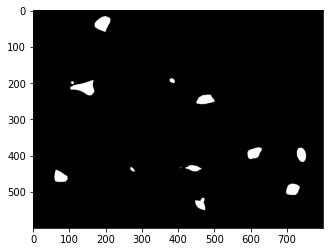

In [4]:
#have to convert data into appropriate type, a filtered image float
imgray=rgb2gray(im)
from skimage.filters import threshold_otsu
myim_threshold = threshold_otsu(imgray)
plt.imshow(imgray > myim_threshold, cmap='gray')

im2=imgray>myim_threshold
im2float= img_as_float(im2)

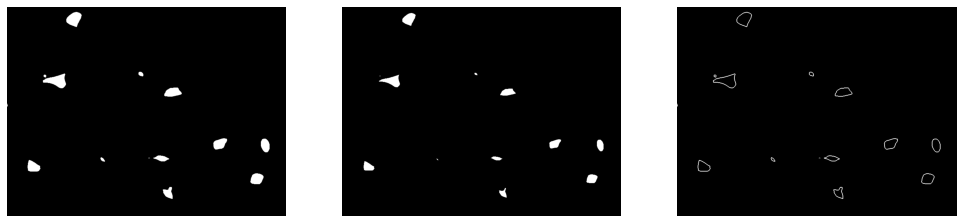

In [5]:
#Boundary extraction method for edge detection
fig, axes = plt.subplots(ncols=3, figsize=(17, 6))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im2float, cmap='gray')
axes[1].imshow(erode(im2float, disk(3)), cmap='gray')
axes[2].imshow(im2float - erode(im2float, disk(2)), cmap='gray')

In [10]:
#we would like to get rid of tiny speckles that remain, as these speckles are very likely not Hela cells
import cv2
from cv2 import connectedComponentsWithStats

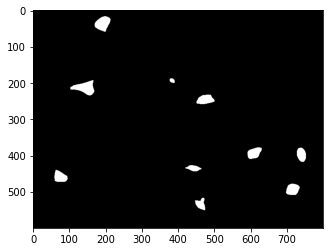

In [11]:
#data conversion
imgPWN=im2float.astype(np.uint8)
#find all your connected components (white blobs in your image, all parameters are needed)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(imgPWN, connectivity=8)
##nb_components.shape

#connectedComponentswithStats yields every seperated component with information on each of them, such as size
#the following part is just taking out the background which is also considered a component, but most of the time we don't want that.

sizes = stats[1:, -1]; nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 100  

#your answer image
img2 = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255

plt.imshow(img2, cmap='gray')

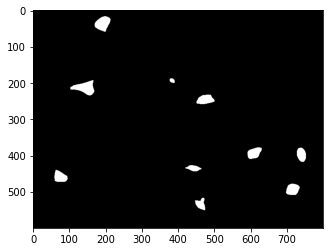

In [14]:
#convert back our speckle free data
imgray2=rgb2gray(img2)
myim_threshold2 = threshold_otsu(imgray2)
plt.imshow(imgray2 > myim_threshold2, cmap='gray')

im22=imgray2>myim_threshold2
im2float2= img_as_float(im22)

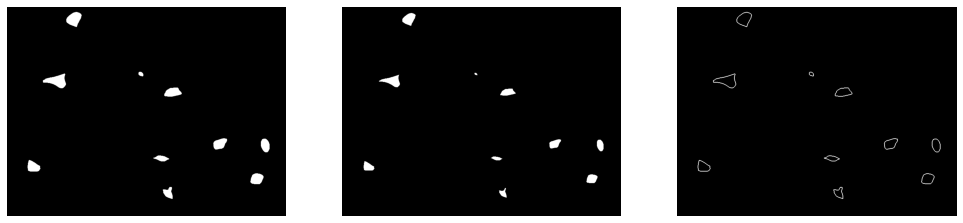

In [13]:
#Speckle free Boundary extraction method for edge detection
fig, axes = plt.subplots(ncols=3, figsize=(17, 6))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im2float2, cmap='gray')
axes[1].imshow(erode(im2float2, disk(3)), cmap='gray')
axes[2].imshow(im2float2 - erode(im2float2, disk(2)), cmap='gray')

Edge detection with Skimage canny function

In [15]:
from skimage.feature import canny
from skimage.morphology import disk, binary_dilation, binary_erosion

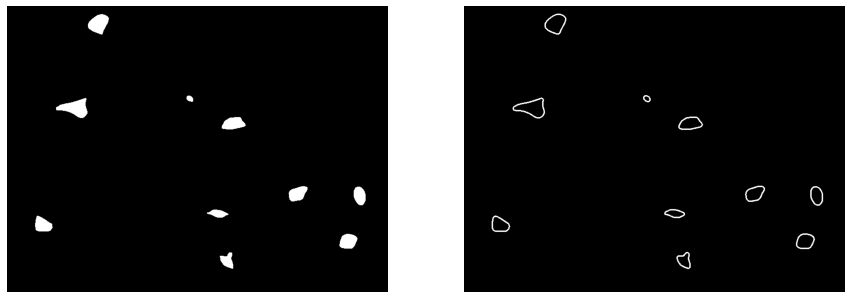

In [16]:
#canny(image,sigma,lower boundary,upperboundary), higher sigma the more resolved it is on the outmost edge
edges = canny(imgray, 3 ,10,90)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].imshow(imgray, cmap='gray')
#axes[1].imshow(edges, cmap='gray')
axes[1].imshow(binary_dilation(edges, disk(1)), cmap='gray')

for ax in axes:
    ax.axis('off')